In [16]:
# Importing libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
# Define avaliable device and data type
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

# Define Main Functions

In [42]:
def featureNormalize(X):
    """
    Returns a normalized version of X where the mean value 
    of each feature is 0 and the standard deviation is 1.
    """
    # calculates mean and standard deviation
    mean = torch.mean(X).cuda()
    std = torch.std(X).cuda()
    
    # normalized each matrix element to have them normally distributed N(0,1) (mean=0, std=1)
    X_norm = (X - mean) / std
    
    return X_norm, mean, std

In [4]:
def covariance(X):
    m, n = X.shape[0], X.shape[1]
    
    X_cov = 1 / (m - 1) * X.T @ X
    
    return X_cov

In [59]:
def pca(X):
    """
    Computes eigenvectors of the covariance matrix of X
    """
    sigma = covariance(X)
    
    U, S, V = torch.svd(sigma)
    print(U.is_cuda, S.is_cuda, V.is_cuda)
    
    return U, S, V

In [93]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when 
    projecting only on to the top k eigenvectors
    """
    m = X.shape[0]
    U_reduced = U[:,:K]
    Z = torch.zeros((m,K)).cuda()
    
    Z[:m, :K] = X[:m, :] @ U_reduced[:, :K]
    
    return Z     # Project the data onto K=1 dimension

In [94]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original 
    data when using the projected data
    """
    m,n = Z.shape[0],U.shape[0]
    X_rec = torch.zeros((m,n)).cuda()
    U_reduced = U[:,:K]

    X_rec[:m, :] = Z[:m, :] @ U_reduced.T
    
    return X_rec

In [50]:
def show_flattened_vectors(matrix, k:int, title:str):
    """Shows first K vectors as an reshaped 32x32 dimensional images from X matrix"""

    # calculate dimension of plot matrix which fits all K feature representations (as images) which will look like as eigenfaces
    PLOT_MATRIX_DIM = 2 if k==1 else int(np.ceil(np.sqrt(k)))

    # take matrix of only that first K features
    reduced_matrix = matrix[:,:k].T

    # plotting compressed images
    fig, ax2 = plt.subplots(PLOT_MATRIX_DIM, PLOT_MATRIX_DIM, figsize=(18,18))

    for i in range(0, PLOT_MATRIX_DIM**2, PLOT_MATRIX_DIM):
        for j in range(PLOT_MATRIX_DIM):
            if i + j < k:
                reshaped_image = reduced_matrix[i+j,:].reshape(32,32,order="F")
                ax2[int(i/PLOT_MATRIX_DIM),j].imshow(reshaped_image,cmap="gray")
                ax2[int(i/PLOT_MATRIX_DIM),j].axis("off")
    _ = fig.suptitle(title, fontsize=30)
                

# Load and visualize the Face image dataset

In [51]:
mat = loadmat("ex7faces.mat")
X = torch.cuda.FloatTensor(mat["X"])

In [52]:
X.size(), X.dtype, X.type

(torch.Size([5000, 1024]), torch.float32, <function Tensor.type>)

## create subplots to show multiple images
1. unflatten image vectors
2. plot images
3. turn off axis to have less noise on plots

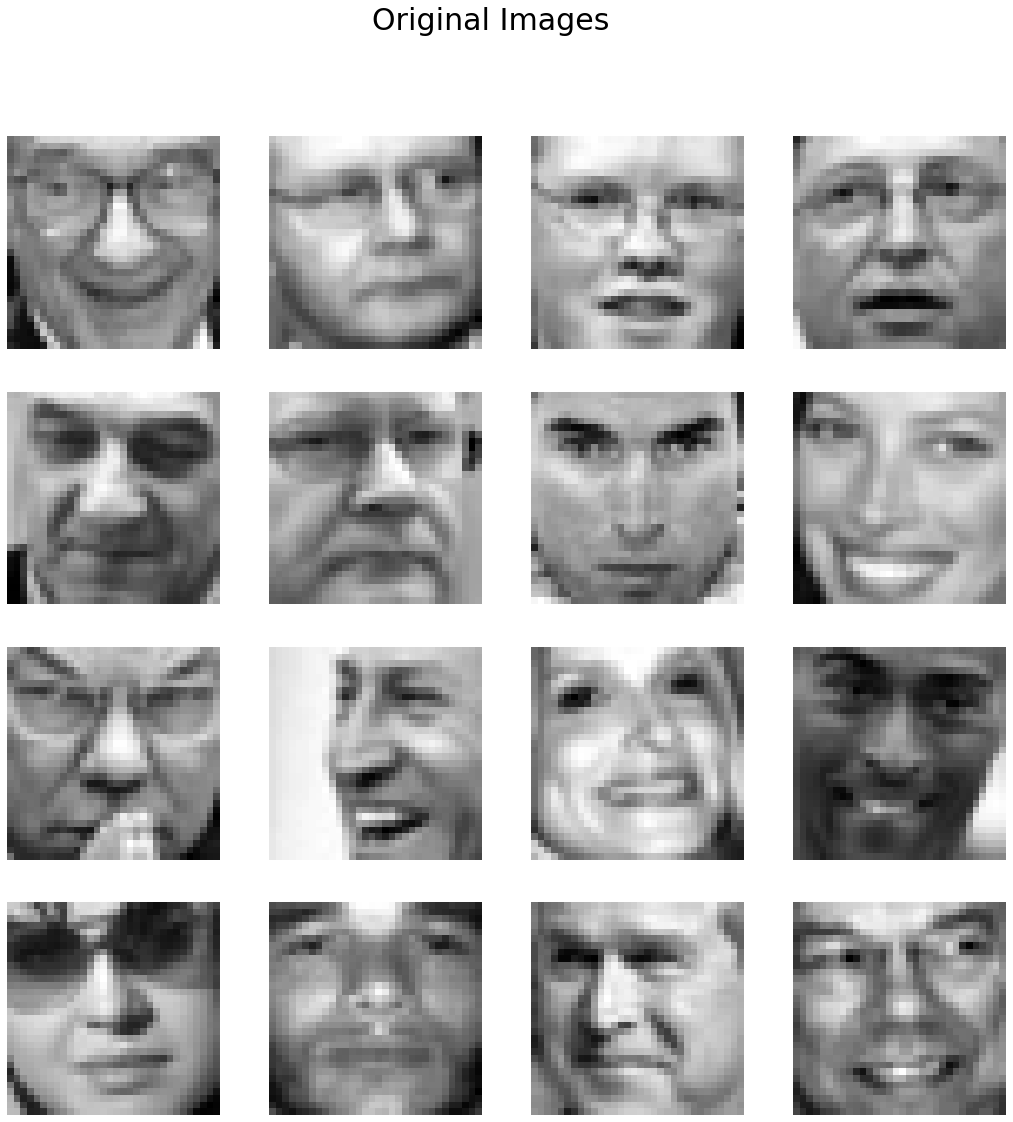

In [53]:
# convert gpu tesnor into numpy array and plot original images
show_flattened_vectors(X.cpu().data.numpy().T, k=16, title='Original Images')

# Normalize matrix of flattened images

In [54]:
%time X_norm, _ , _ = featureNormalize(X)
X_norm.shape

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 1.61 ms


torch.Size([5000, 1024])

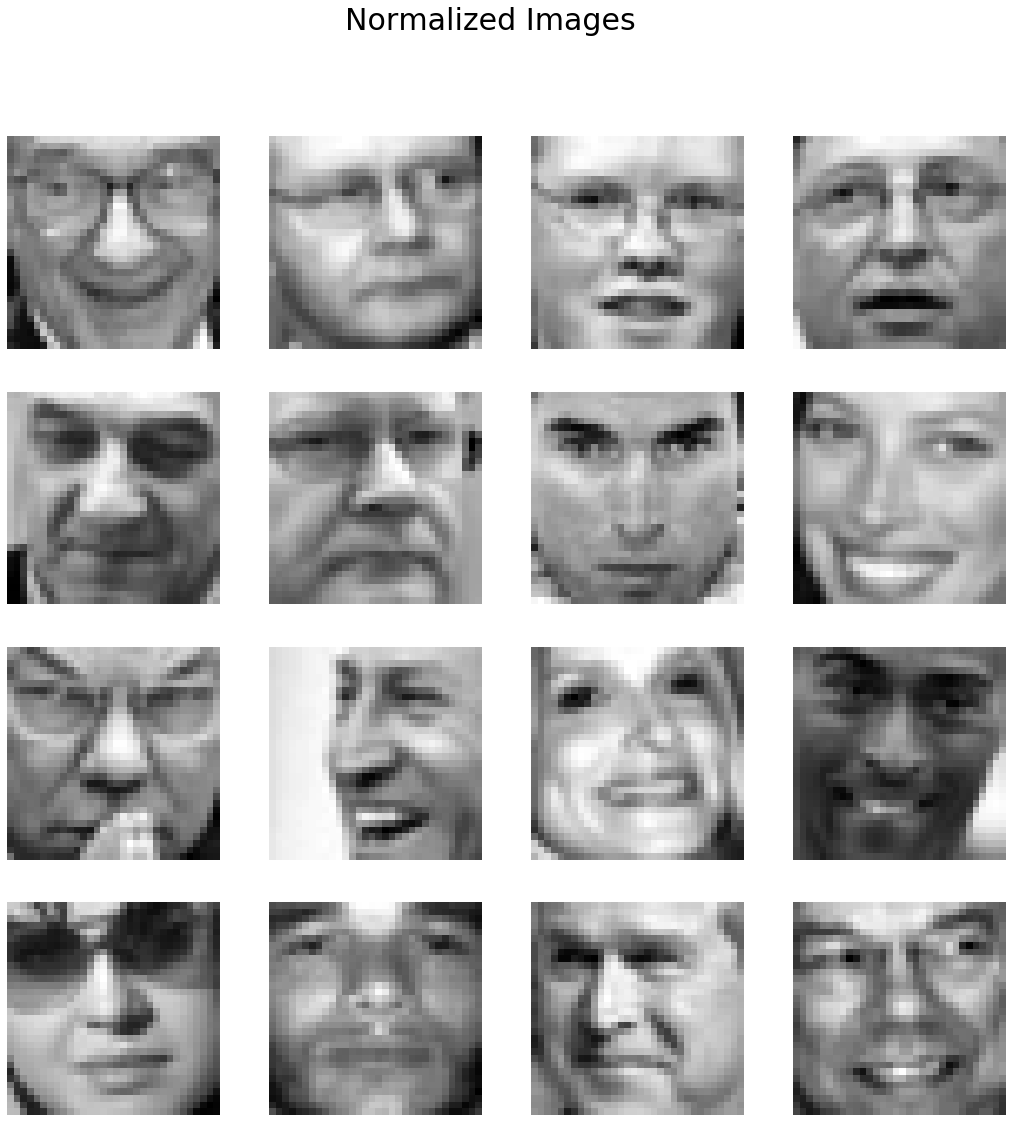

In [55]:
show_flattened_vectors(X_norm.cpu().data.numpy().T, k=16, title='Normalized Images')

### Run PCA

**U** and **V** are **left singular** and **right singular** vectors of covariance matrix of **X normalized** matrix

**S** is known as singular values vector which in fact is a representation of diagonal matrix

In [64]:
%time U, S, V = pca(X_norm)

True True True
CPU times: user 606 ms, sys: 27.1 ms, total: 633 ms
Wall time: 244 ms


# Understanding U, S, V matrices

In [66]:
X_norm.shape

torch.Size([5000, 1024])

In [67]:
U.shape, S.shape, V.shape

(torch.Size([1024, 1024]), torch.Size([1024]), torch.Size([1024, 1024]))

## $U$ and $V^T$ are equal (Almost) because they are containing left and right singular vectors of covariance matrix which is symmetric

In [68]:
U[1,:]

tensor([-0.0169, -0.0411, -0.0441,  ..., -0.0002,  0.0008,  0.0010],
       device='cuda:0')

In [70]:
V.T[:,1]

tensor([-0.0169, -0.0411, -0.0441,  ..., -0.0003,  0.0005,  0.0007],
       device='cuda:0')

In [73]:
torch.norm(U - V.T)

tensor(45.1804, device='cuda:0')

# Show Singular Values

## All singular values

<BarContainer object of 1024 artists>

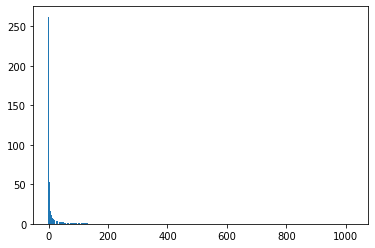

In [78]:
plt.bar(range(S.cpu().shape[0]), S.cpu())

In [79]:
U.shape

torch.Size([1024, 1024])

In [80]:
V.shape

torch.Size([1024, 1024])

## Top 50 singular values

<BarContainer object of 50 artists>

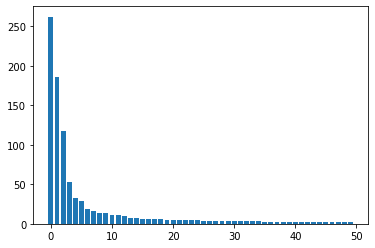

In [82]:
plt.bar(range(50), S.cpu()[:50])

# Below is the visualization of 36 principal componentsÂ or eigenvectors or eigenfaces that describe the largest variations in the dataset

These vectors are looking as if they were reduces form of original images but they are eigenfaces. If we want to map our n=1024 dimensional images into lower K dimensional (K<<n) space, we are saving coefficients for first K eigenvectors/eigenfaces and then we can get reconstruction (approximate) of original images with linear combination of these first K important eigenfaces with saved coefficients. 

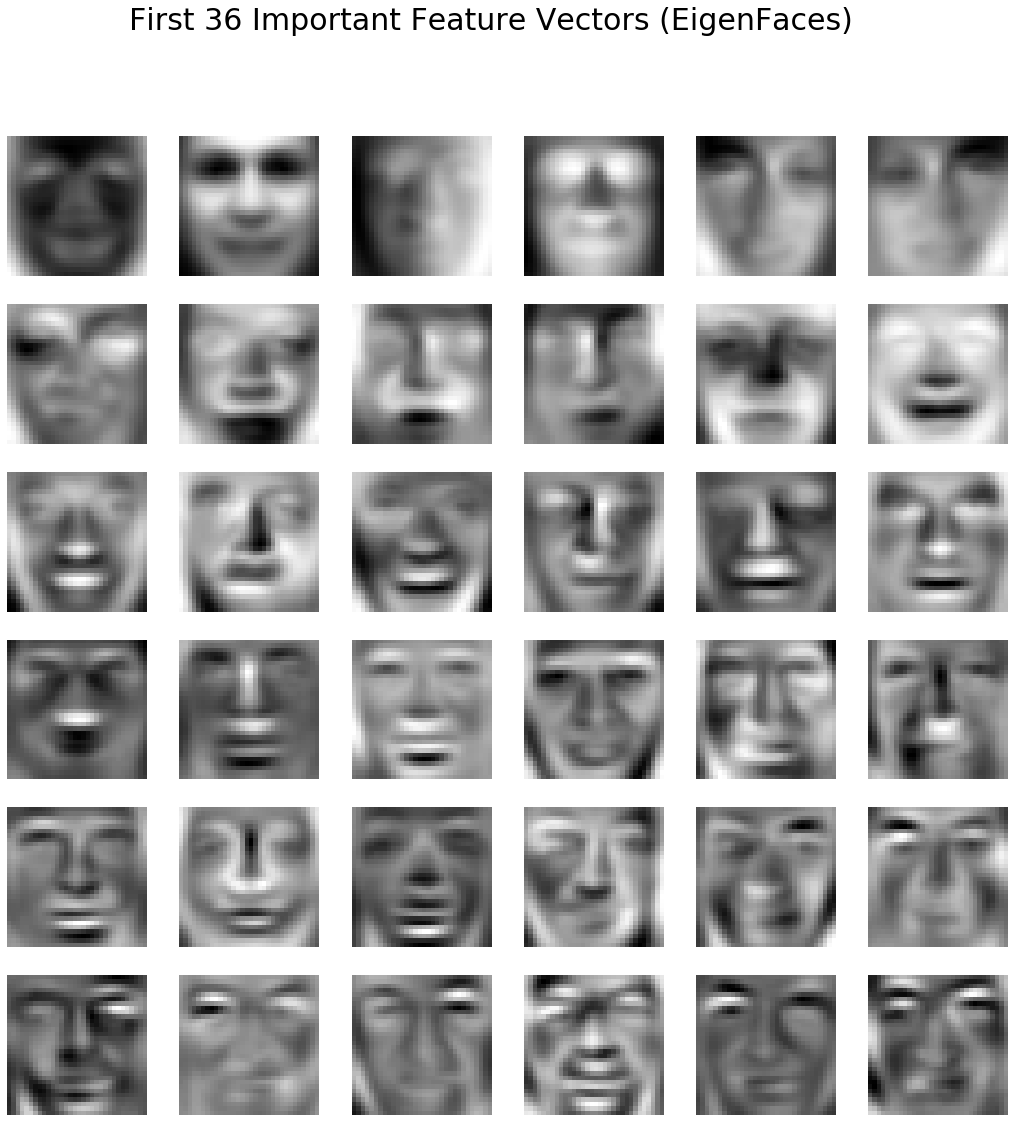

In [85]:
show_flattened_vectors(U.cpu().data.numpy(), k=36, title='First 36 Important Feature Vectors (EigenFaces)')

# Let's try to take 36 last principal components instead of first. We will see that these last eigenfaces aren't impressive since they contain almost random noise.

I am just passing matrix of last 36 feature vectors as a parameter to avoid problems with indices since it takes first K element and it's impossible to access slice of [:, -k:] 

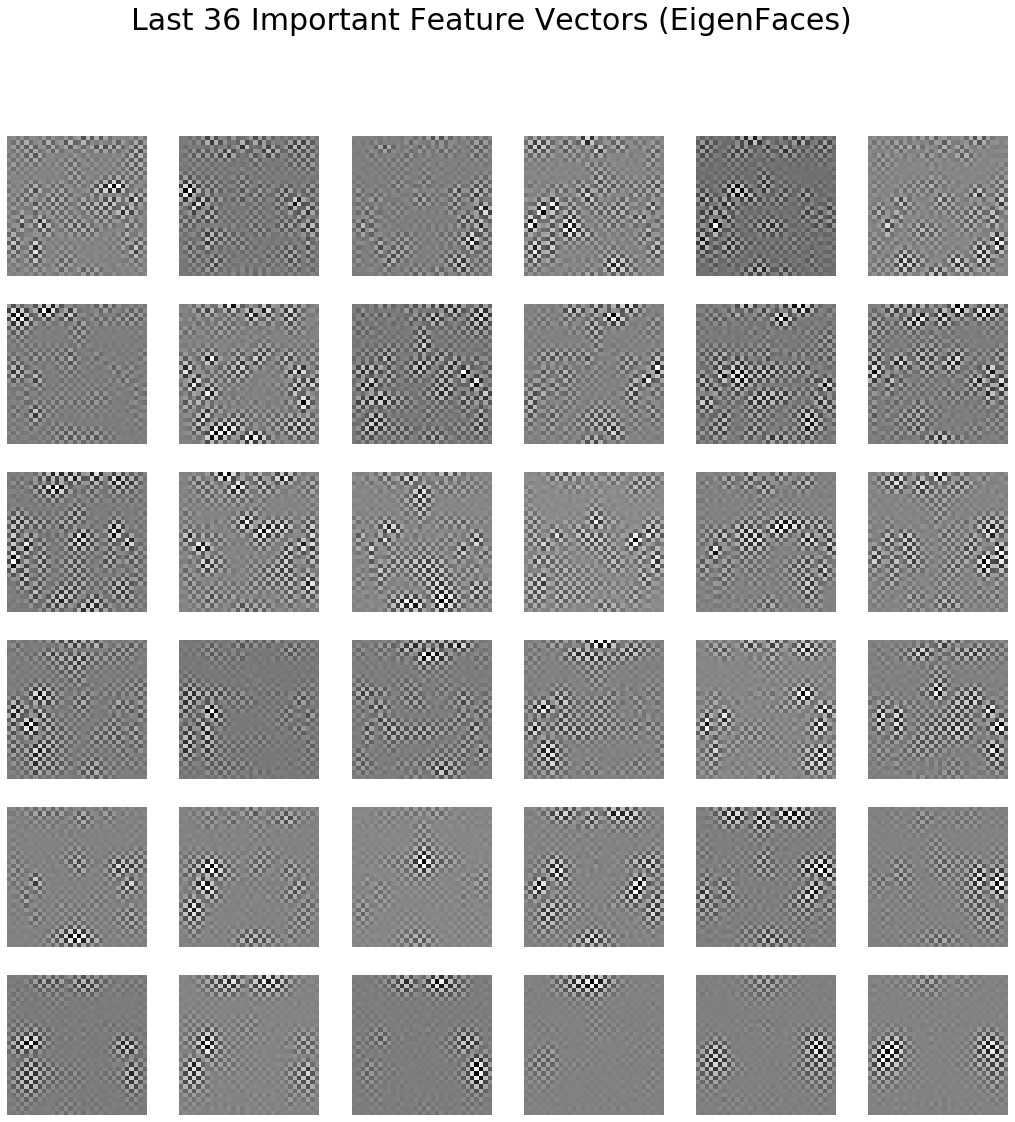

In [87]:
show_flattened_vectors(U.cpu().data.numpy()[:,-36:], k=36, title='Last 36 Important Feature Vectors (EigenFaces)')

# Let's project the data onto the first K=100 principal components and recover back. Try to understand what is lost in the dimensionality reduction process.

In [95]:
K = 100
Z = projectData(X_norm, U, K)
print("The projected data Z has a size of:", Z.shape)

### Data reconstruction
X_rec  = recoverData(Z, U, K)

The projected data Z has a size of: torch.Size([5000, 100])


### Visualize the reconstructed data

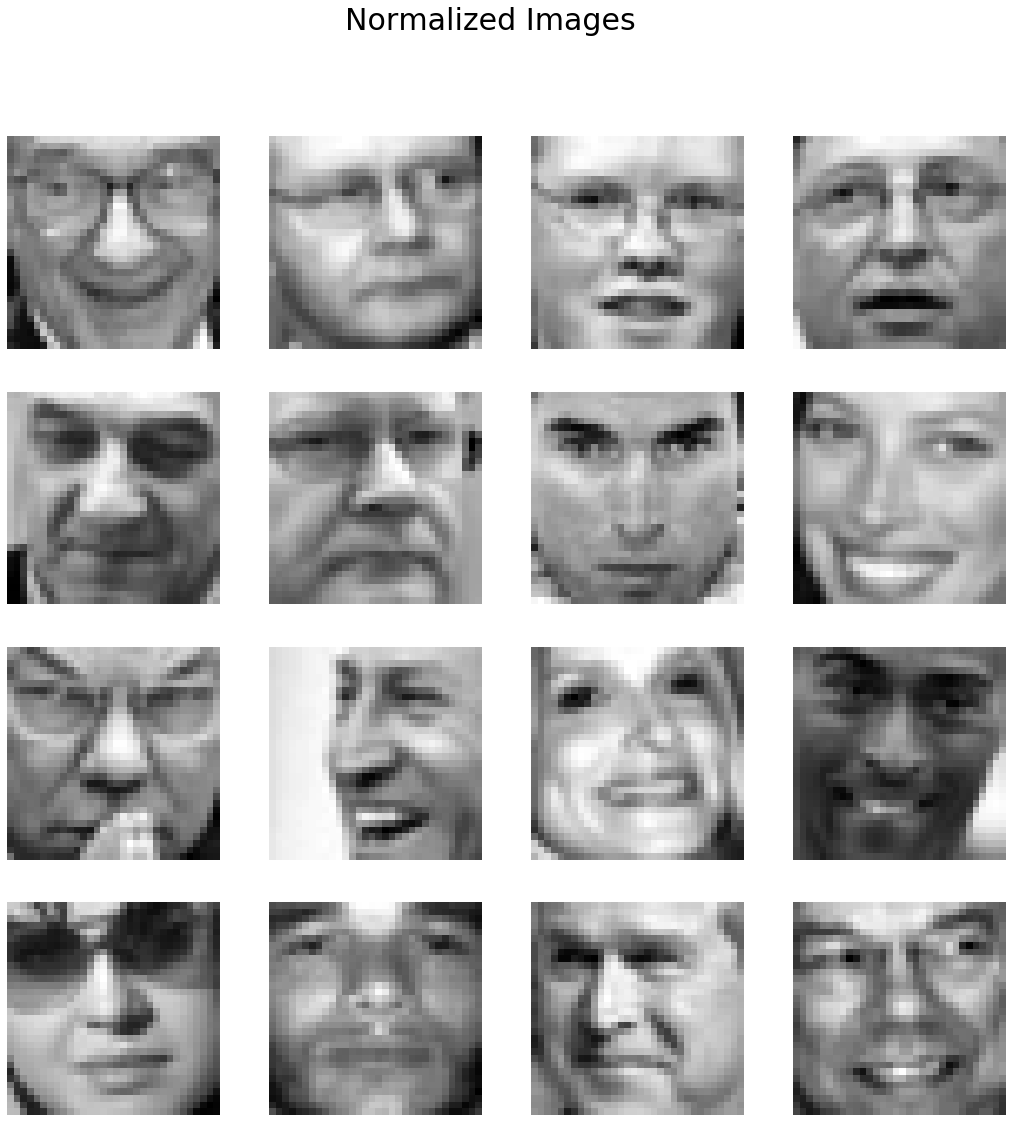

In [96]:
show_flattened_vectors(X_norm.cpu().data.numpy().T, k=16, title='Normalized Images')

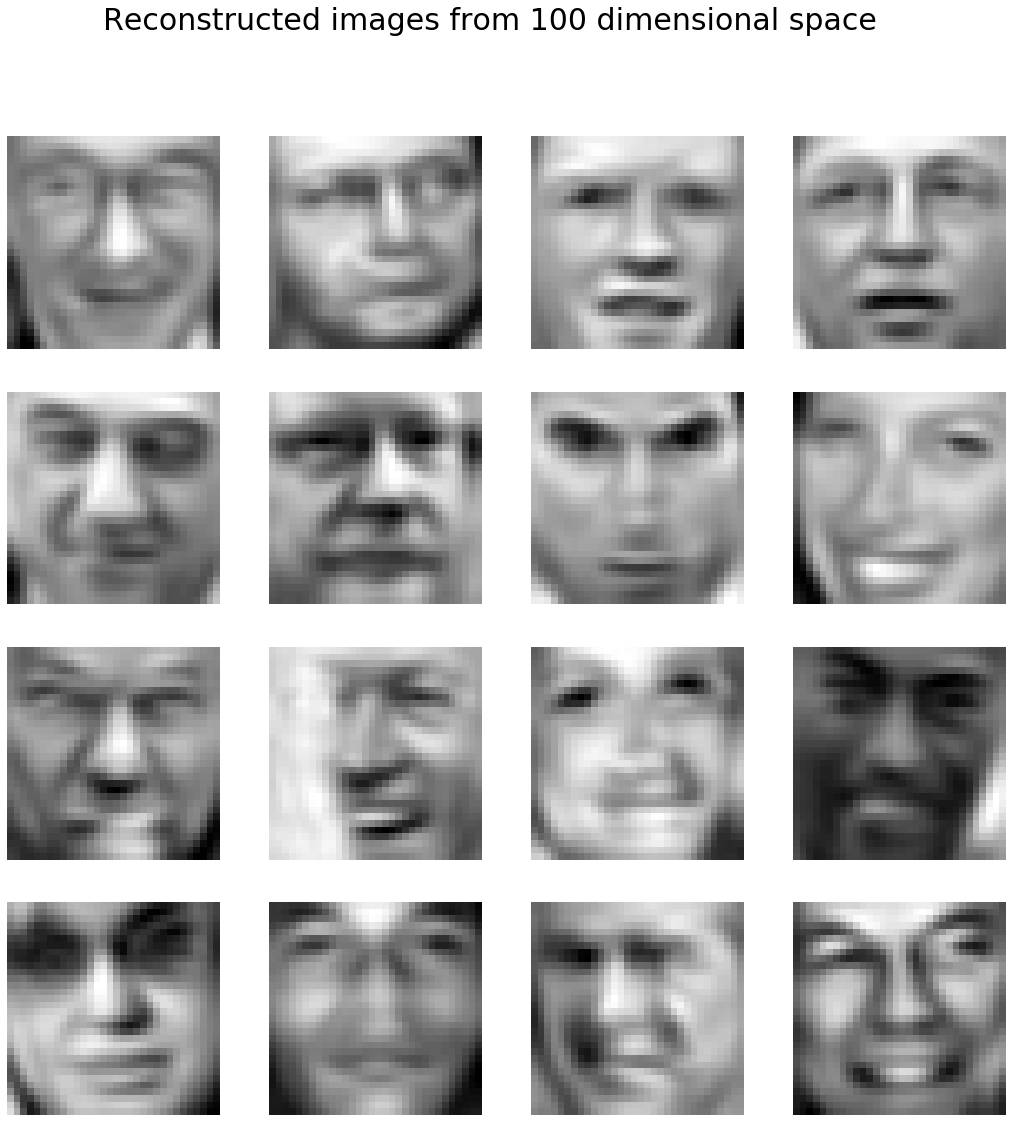

In [97]:
show_flattened_vectors(X_rec.cpu().data.numpy().T, k=16, title=f"Reconstructed images from {K} dimensional space")

# Let's project the data onto the first K=1 principal components and recover back. Try to understand what is lost in the dimensionality reduction process.

In [98]:
K = 1
Z = projectData(X_norm, U, K)
print("The projected data Z has a size of:", Z.shape)

### Data reconstruction
X_rec  = recoverData(Z, U, K)

The projected data Z has a size of: torch.Size([5000, 1])


### Visualize the reconstructed data

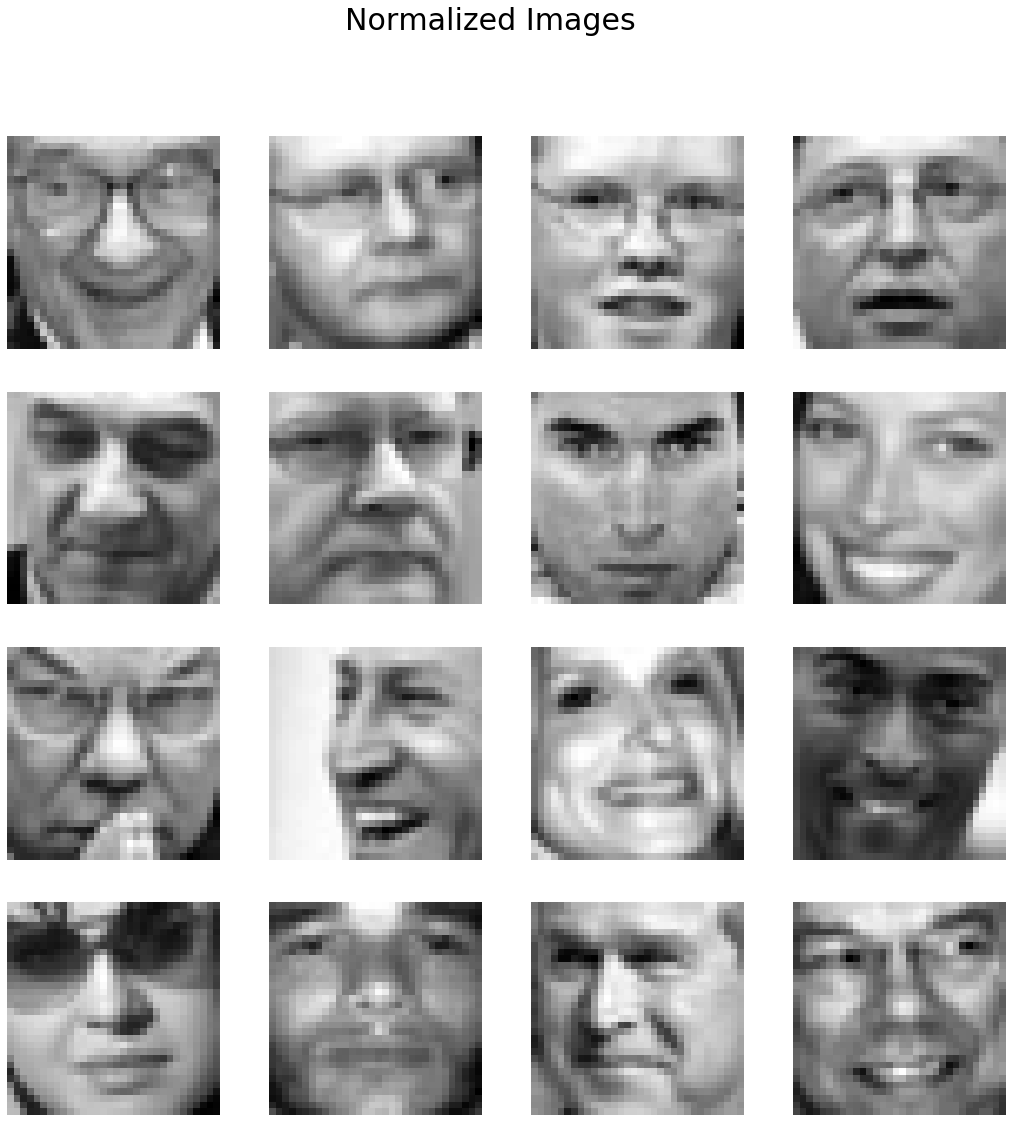

In [99]:
show_flattened_vectors(X_norm.cpu().data.numpy().T, k=16, title='Normalized Images')

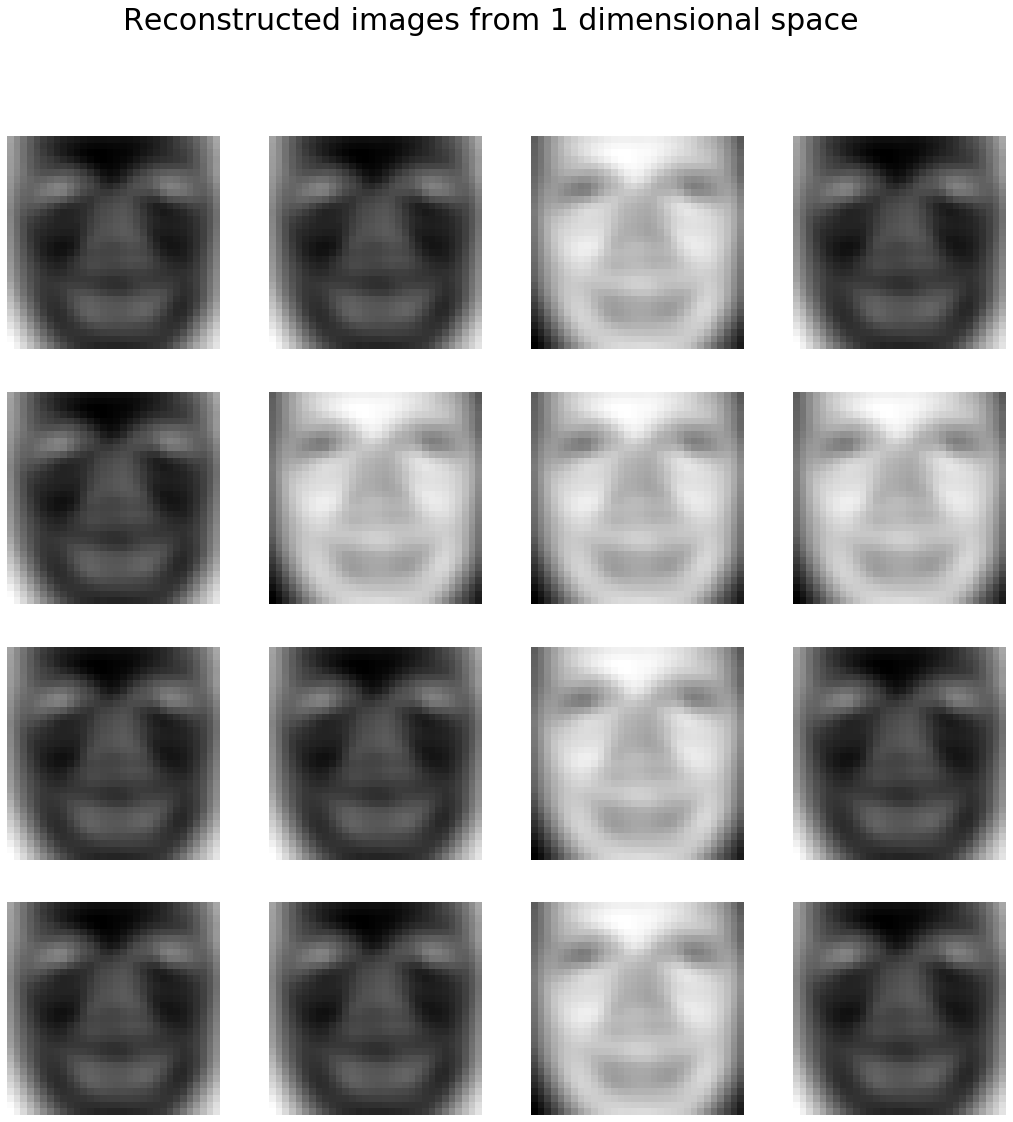

In [100]:
show_flattened_vectors(X_rec.cpu().data.numpy().T, k=16, title=f"Reconstructed images from {K} dimensional space")

If we check first feature with highest singular value in V matrix we will see that all of these representations of images come from that feature with little scaling. They are multiplied with the coefficient to have their reconstruction as close as possible with original images

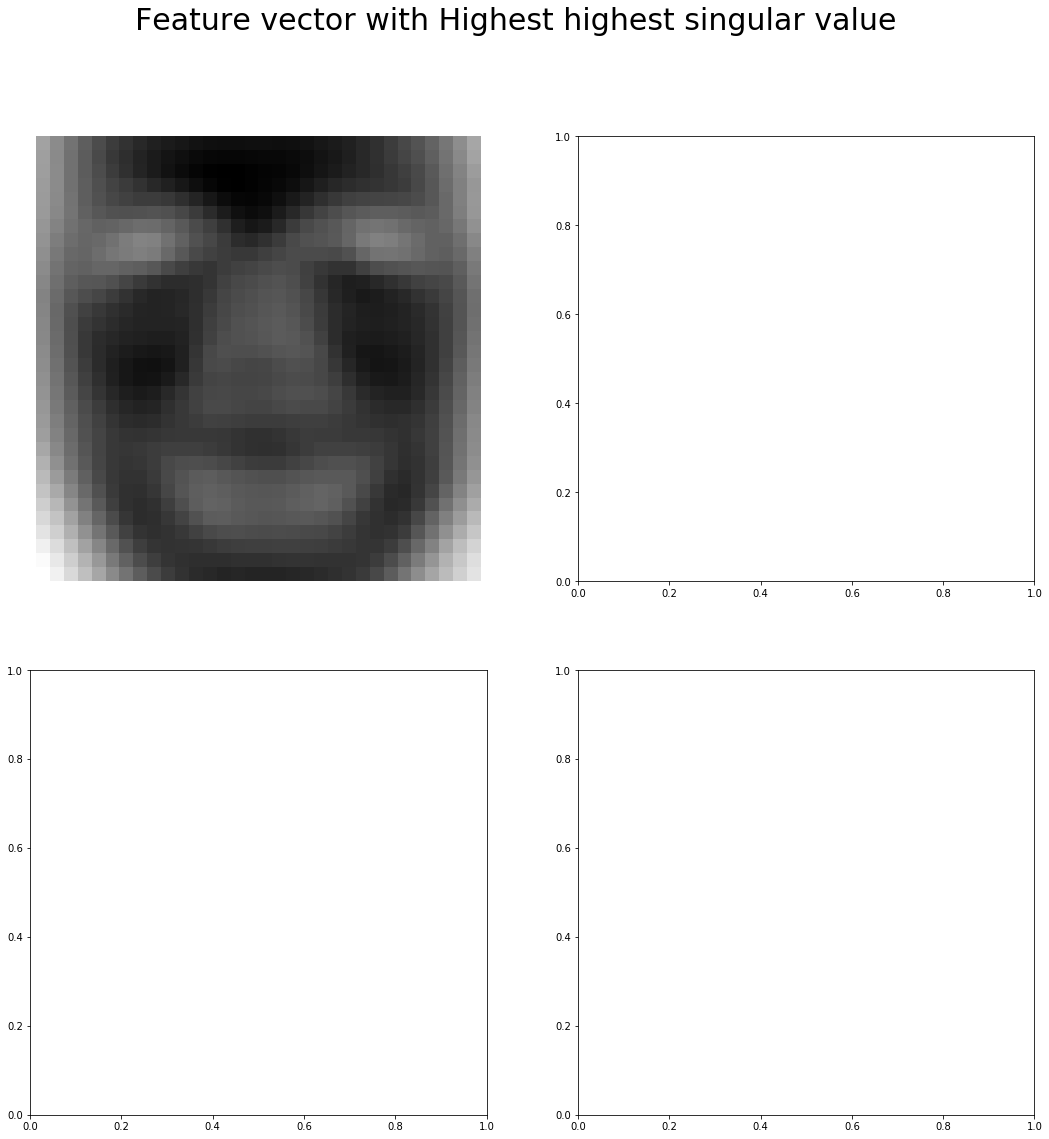

In [102]:
show_flattened_vectors(U.cpu().data.numpy(), k=1, title='Feature vector with Highest highest singular value')